<div style="padding: 25px;
            color: white;
            margin: 10px;
            font-size: 200%;
            text-align: center;
            display: flex;
            align-items: center;
            justify-content: center;
            border-radius: 20px;
            background-color: #5DADE2;
            overflow: hidden;
            font-weight: bold;
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);">
            Medical Cost Personal
</div>

***Dataset : https://www.kaggle.com/datasets/mirichoi0218/insurance/code***

## `Columns Details:` 
- **age**: age of primary beneficiary
- **sex**: insurance contractor gender, female, male
- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,objective index of body weight 
(kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- **children**: Number of children covered by health insurance / Number of dependents
- **smoker**: Smoking
- **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- **charges**: Individual medical costs billed by health insurance

## 1. Import Libraries.

In [1]:
import numpy as np
import pandas as pd

## viz. libraries
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode

## split data
from sklearn.model_selection import train_test_split

## Pipeline
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn_features.transformers import DataFrameSelector

## preprocessing 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## cross validation 
from sklearn.model_selection import cross_validate

## Hyper. Tuning
from sklearn.model_selection import RandomizedSearchCV

## metric
from sklearn.metrics import r2_score

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Customize Seaborn
sns.set(rc={"figure.figsize" : [12,8]}, style="whitegrid", font_scale=1.2)
sns.set_palette("Set2")

## Customize Plotly
px.defaults.template = "plotly_white"
init_notebook_mode(connected=True)
px.defaults.width = 800
px.defaults.height = 500

## 2. Load DataSet.

In [2]:
data = pd.read_csv("insurance.csv")

In [3]:
data.head() ## show first 5 rows

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Overview about the Data

In [4]:
data.info() ## information about the data such as datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.shape ## return (num of rows, num of cols)

(1338, 7)

**The data contains 1338 rows and 7 columns**

In [6]:
data.isna().any() ## cheack missing values

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [7]:
data.duplicated().sum() ## check duplicate rows

1

In [8]:
data.drop_duplicates(inplace=True) ## drop Duplicated rows

In [9]:
round(data.describe(include="number")) ## Statsical info. about the data 

,age,bmi,children,charges
count,1337.0,1337.0,1337.0,1337.0
mean,39.0,31.0,1.0,13279.0
std,14.0,6.0,1.0,12110.0
min,18.0,16.0,0.0,1122.0
25%,27.0,26.0,0.0,4746.0
50%,39.0,30.0,1.0,9386.0
75%,51.0,35.0,2.0,16658.0
max,64.0,53.0,5.0,63770.0


In [10]:
data.describe(exclude="number")

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


- **Age** : in the data range from 14 to 64
- **bmi** : the mean of bmi = 31.0
- **children** : Average number in the data = 1, and there are people who do not have children
- **charges** : Obviously there are outliers

## 4. EDA & Data Analysis

### 4.1 Univariate analysis

#### 4.1.1 Numerical Columns

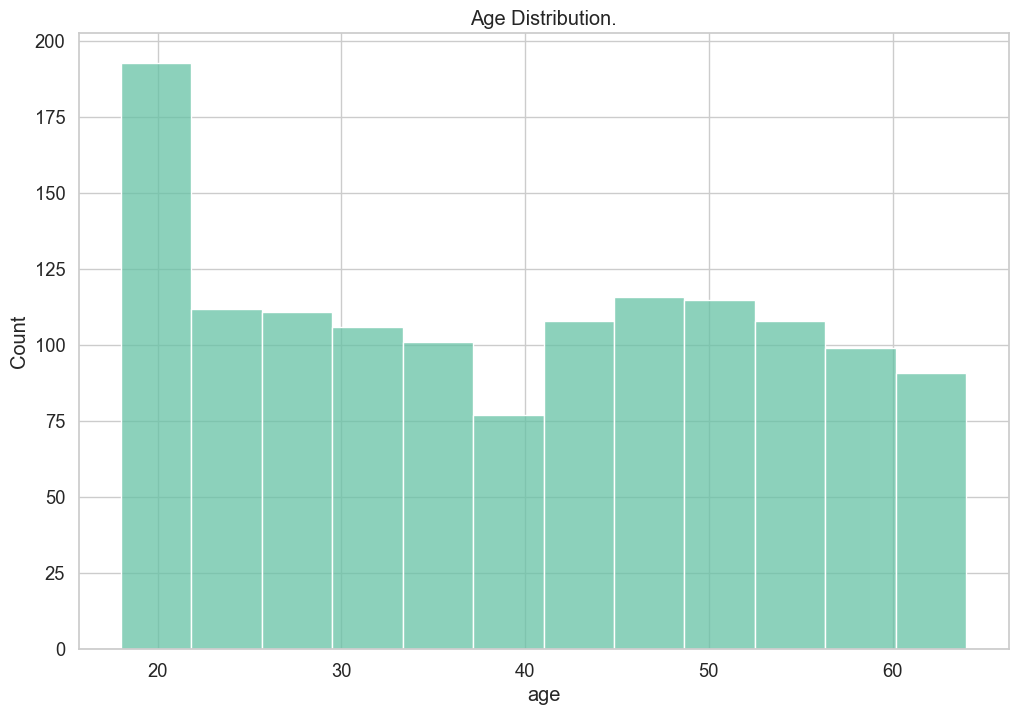

In [11]:
sns.histplot(data, x="age")
plt.title("Age Distribution.")
plt.show()

**From the chart above :**
- **the high density of people in range 18 to 23**

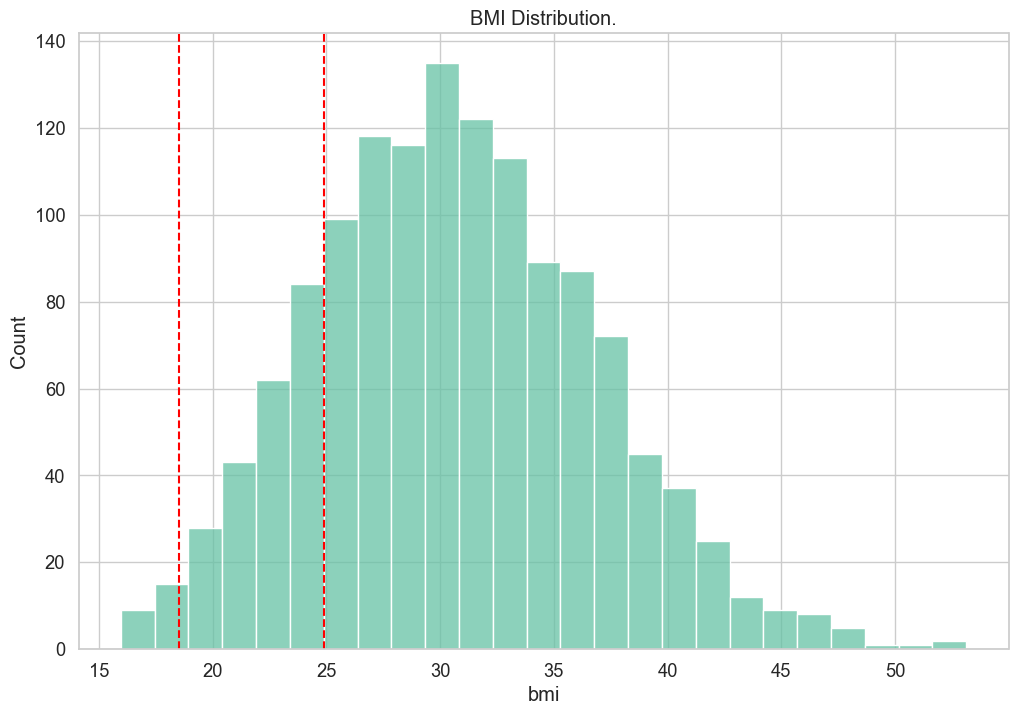

In [12]:
sns.histplot(data=data, x="bmi")
plt.title("BMI Distribution.")
plt.axvline(18.5, color="red", linestyle='--')
plt.axvline(24.9, color="red", linestyle='--')
plt.show()

**From the chart above :**
- **BMI : the distribution is normal distribution**
- **from the describtion of data, the BMI range is 18.5 to 24.9.**
- ***There are a large number of people who are overweight***

In [13]:
## (len(data[(data['bmi'] > 18.5) & (data['bmi'] < 24.9)]) / 1338) * 100
normal = ((data['bmi'] > 18.5) & (data['bmi'] < 24.9)).mean()

## (len(data[data['bmi'] > 24.9]) / 1338) * 100
over =  (data['bmi'] > 24.9).mean()

print(f"Normal weight: {round(normal,2)*100}%\nOverweight: {round(over,2)*100}%")

Normal weight: 17.0%
Overweight: 82.0%


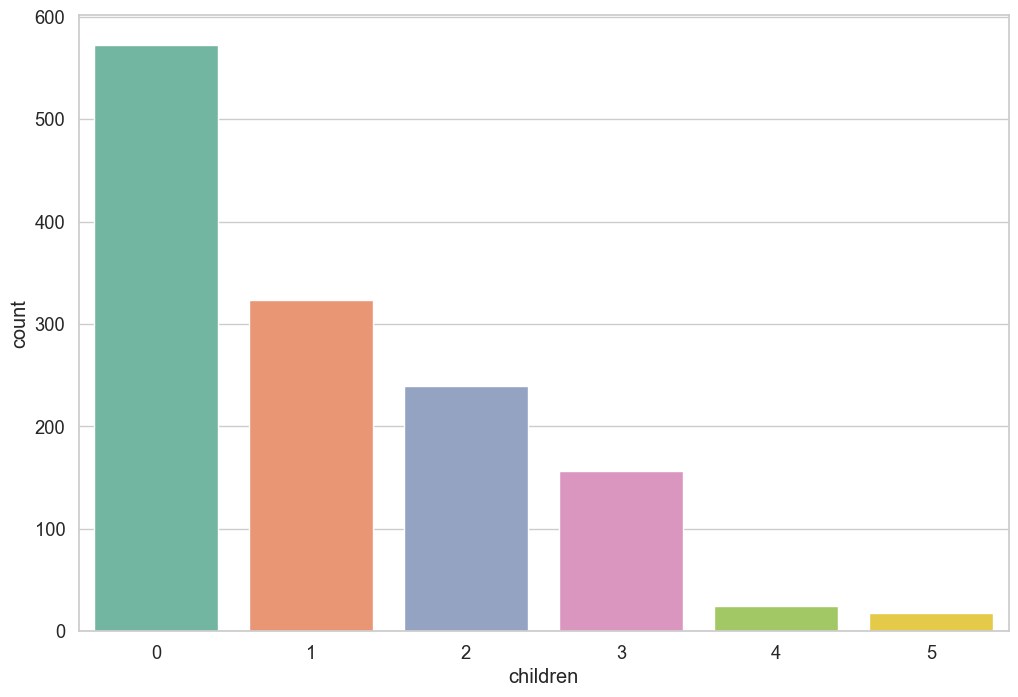

In [14]:
sns.countplot(data=data, x="children")
plt.show()

In [15]:
data["children"].value_counts()

0    573
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

**From the chart above :**
- **Most people in the data do not have children**

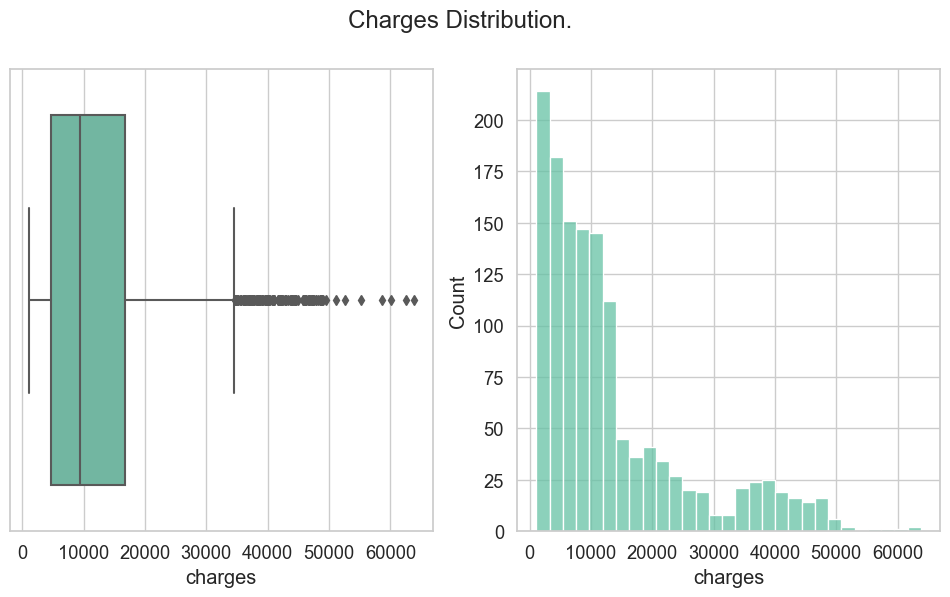

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(data, x="charges", ax=axis[0])
sns.histplot(data, x="charges", ax=axis[1])
fig.suptitle("charges Distribution.".title())
plt.show()

**From the chart above :**
- **There are outliers in the charges column**
- **Right skewed distribution**
- **Most people's charges range from 1122 to 16600**

In [17]:
print(f"The number of people whose charges are higher than 16600 : {len(data.loc[data['charges']>16600,:])}")

The number of people whose charges are higher than 16600 : 335


#### 4.1.2 Categorical Columns

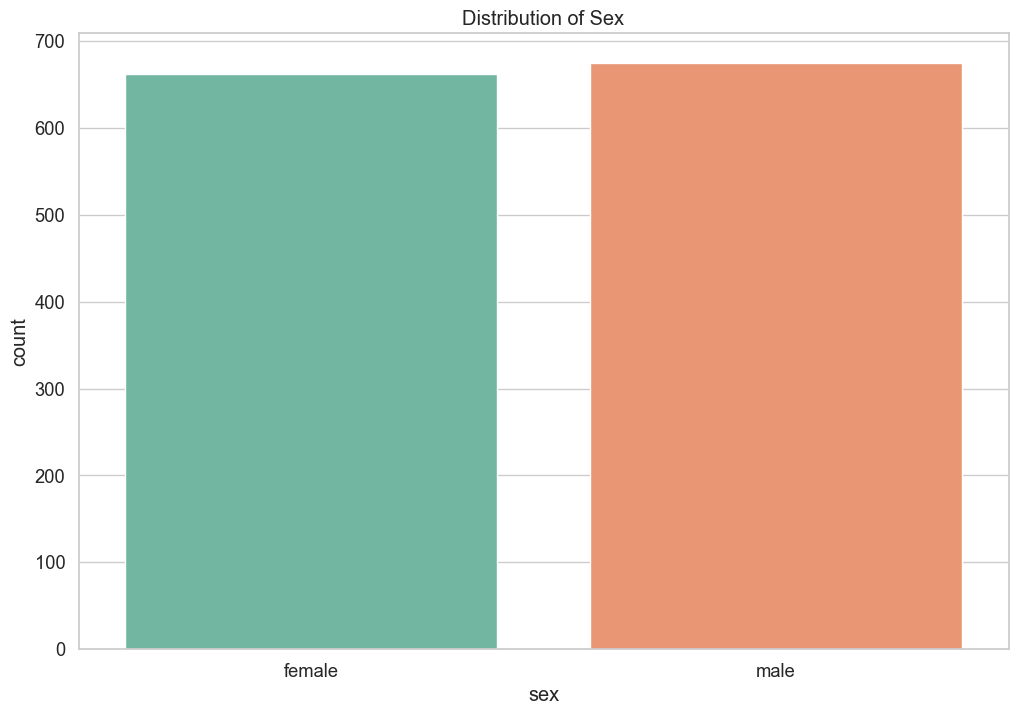

In [18]:
sns.countplot(data=data, x="sex")
plt.title("Distribution of Sex")
plt.show()

In [19]:
data["sex"].value_counts()

male      675
female    662
Name: sex, dtype: int64

**the number of male and female is almost equal.**

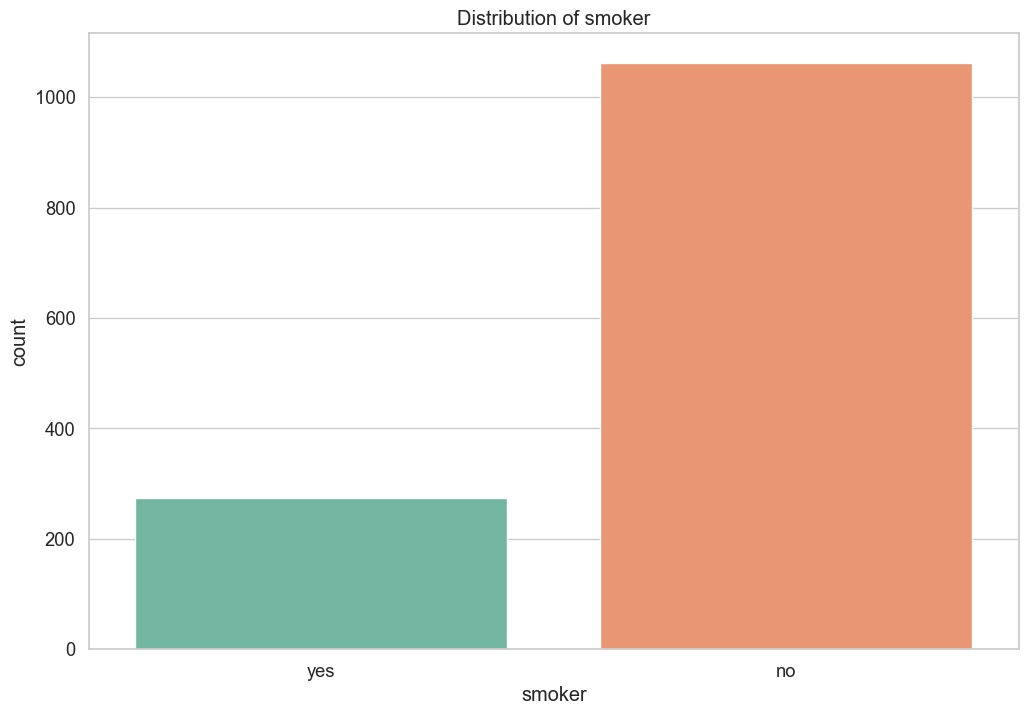

In [20]:
sns.countplot(data=data, x="smoker")
plt.title("Distribution of smoker")
plt.show()

In [21]:
data["smoker"].value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

**Most people don't smoke**

In [22]:
region_count = data["region"].value_counts()
region_count

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

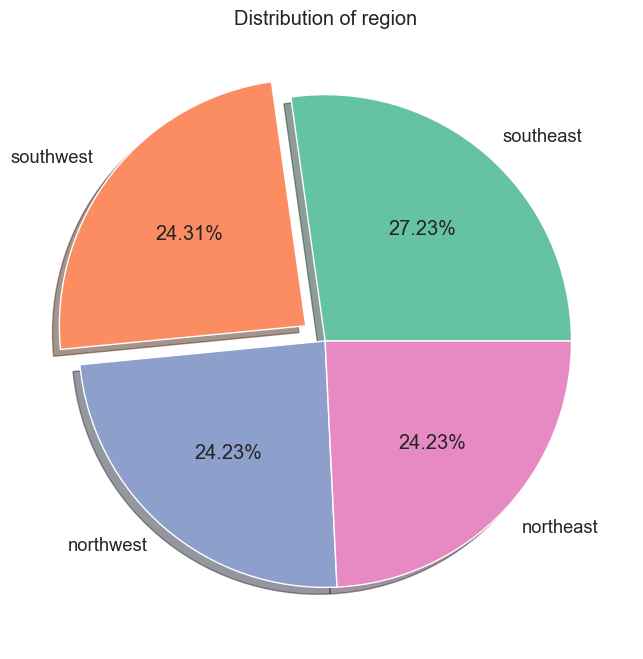

In [23]:
plt.pie(labels=region_count.index,
        x=region_count.values,
        shadow=True,
        autopct = '%.2f%%',
        explode = (0, 0.1, 0, 0))
plt.title("Distribution of region")
plt.show()

**Distribute the regions in the data almost evenly**

## 4.2 Bi-variate Analysis & Multi-variate Analysis

#### `1. How does age affect the relationship between BMI (Body Mass Index) and insurance charges?`

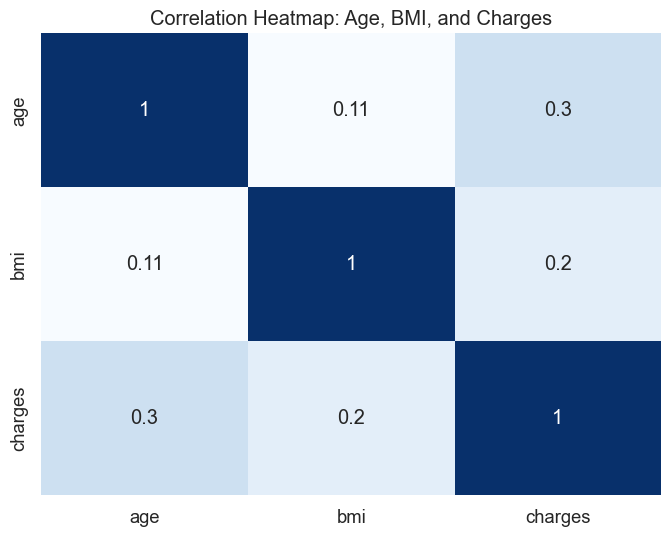

In [24]:
corr_data = data[["age", "bmi", "charges"]].corr()

plt.figure(figsize=(8, 6))  # the figure size
sns.heatmap(round(corr_data, 2), annot=True, cmap="Blues", cbar=False)
plt.title("Correlation Heatmap: Age, BMI, and Charges")  
plt.show()

- **The Correlation between age and weight is very weak**
- **There is a positive Correlation between age and charges = 0.3**
- **let's show it in scatter plot**

In [25]:
fig = px.scatter(data_frame=data, y="charges", x="age",
                 title="<b>the correlation between age and charges".title(),
                 color_discrete_sequence=px.colors.qualitative.D3_r)
fig.show()

In [26]:
fig = px.scatter(data_frame=data, y="charges", x="bmi",
                 title="<b>the correlation between BMI and charges".title(),
                 color_discrete_sequence=px.colors.qualitative.D3_r)
fig.show()

#### `2. is there a relationship between smoking status and insurance charges, considering the age of the individuals?`

In [27]:
fig = px.scatter(data_frame=data, x="age", y="charges", facet_row="smoker", color="smoker",
                 color_discrete_sequence=px.colors.qualitative.D3_r,
                 title="<b>Age vs. Insurance Charges (Colored by Smoker Status)",
                 labels={"age": "Age", "charges": "Insurance Charges"})

fig.show()

In [28]:
data.groupby("smoker")["charges"].mean().to_frame()

,charges
smoker,
no,8440.660307
yes,32050.231832


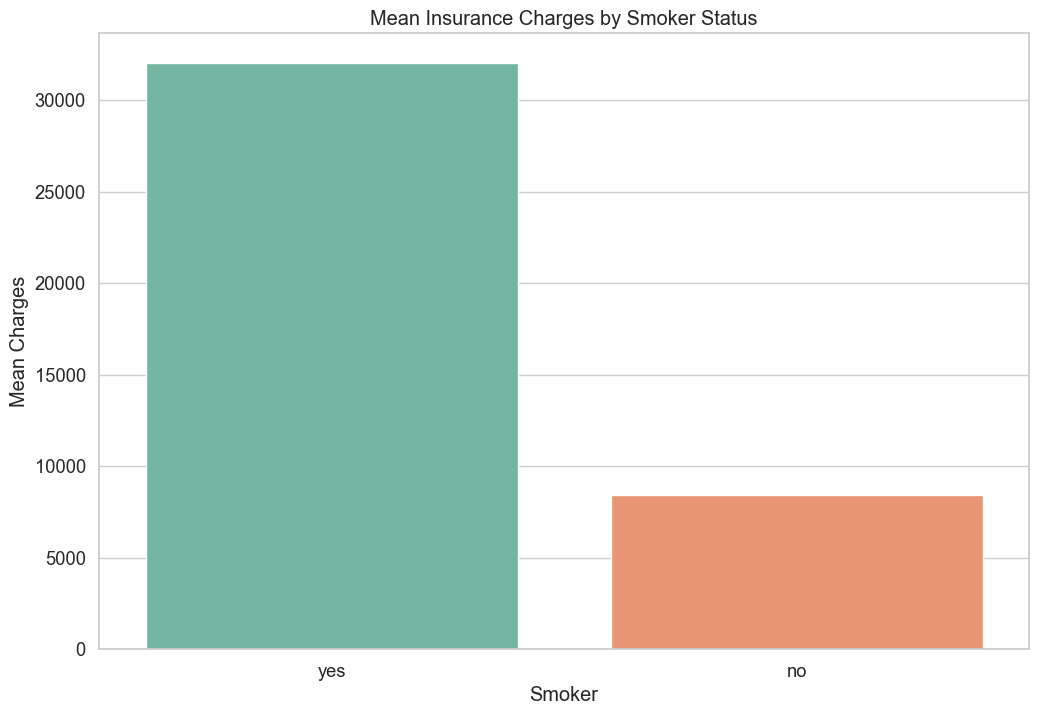

In [29]:
sns.barplot(data=data, x="smoker", y="charges", estimator="mean", ci=False)
plt.title("Mean Insurance Charges by Smoker Status")
plt.xlabel("Smoker")
plt.ylabel("Mean Charges")
plt.show()

**From the charts above :**
- **the insurance charges of smoker peoples is higher than non-smoker.**
- **The correlation pattern of people who smoke is different from that of non-smokers.**

In [30]:
## the corr. between the charges and age for smoker peoples
round(data[data["smoker"] == "yes"][["charges","age"]].corr(),2)

,charges,age
charges,1.00,0.37
age,0.37,1.00


In [31]:
## the corr. between the charges and age for non-smoker peoples
round(data[data["smoker"] == "no"][["charges","age"]].corr(),2)

,charges,age
charges,1.00,0.63
age,0.63,1.00


***There is a strong positive correlation between `age and insurance charges` among `non-smokers`***

#### `3. How does smoking status affect the relationship between BMI (Body Mass Index) and insurance charges?`

In [32]:
fig = px.scatter(data_frame=data, x="bmi", y="charges", color="smoker",
                 color_discrete_sequence=px.colors.qualitative.D3_r,
                 title="<b>BMI vs. Insurance Charges (Colored by Smoker Status)",
                 labels={"bmi": "BMI", "charges": "Insurance Charges"})

fig.show()

In [33]:
## the corr. between the charges and bmi for smoker peoples
round(data[data["smoker"] == "yes"][["charges","bmi"]].corr(),2)

,charges,bmi
charges,1.00,0.81
bmi,0.81,1.00


In [34]:
## the corr. between the charges and bmi for non-smoker peoples
round(data[data["smoker"] == "no"][["charges","bmi"]].corr(),2)

,charges,bmi
charges,1.00,0.08
bmi,0.08,1.00


**From the chart above :**
- **There is a Positive Correlation between BMI and Charges for people who smoke**

#### `region vs. charges`

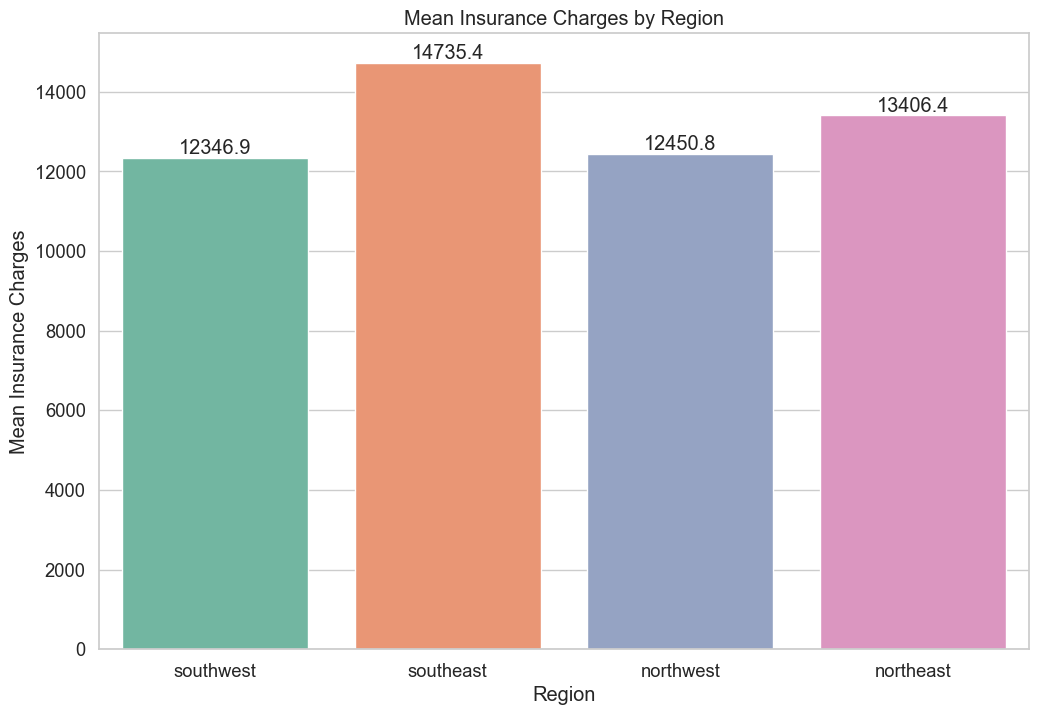

In [35]:
ax = sns.barplot(data=data, x="region", y="charges", estimator="mean", ci=False)
for i in ax.containers:
    ax.bar_label(i)
plt.title("Mean Insurance Charges by Region")
plt.ylabel("Mean Insurance Charges")
plt.xlabel("Region")
plt.show()

In [36]:
regions = data["region"].unique()

In [37]:
total_smoker = len(data[data["smoker"] == "yes"])
smoker_south = len(data[(data["smoker"] == "yes") & (data["region"] == "southeast")])
print((smoker_south/total_smoker)*100)

33.21167883211679


In [38]:
for region in regions : 
    print(f"the mean of BMI in {region} : {data[data['region'] == region]['bmi'].mean()}")

the mean of BMI in southwest : 30.59661538461538
the mean of BMI in southeast : 33.35598901098901
the mean of BMI in northwest : 29.195493827160494
the mean of BMI in northeast : 29.173503086419753


**From the chart above :**
- **The Southeast has the highest insurance charges, why ? -_- This may be due to an increase in the number of smokers or increased BMI levels**

## 5. Split Data

In [39]:
X = data.drop(columns=["charges"], axis=1)
y = data["charges"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, shuffle=True)

## check the shape of spliting data
print(f"the shape of X train: {X_train.shape}")
print(f"the shape of y train: {y_train.shape}")

print("*"*30)

print(f"the shape of X test: {X_test.shape}")
print(f"the shape of y test: {y_test.shape}")

the shape of X train: (1069, 6)
the shape of y train: (1069,)
******************************
the shape of X test: (268, 6)
the shape of y test: (268,)


## 6. PipeLine
- **Bulid pipeline for numerical columns**
- **Bulid pipeline for categorical columns**
- **Union all together**

***`NOTE` : We assume that we have missing values.***

In [41]:
Numerical_columns = X.select_dtypes(include="number").columns.to_list()
Categorical_columns = X.select_dtypes(exclude="number").columns.to_list()
print(f"Numerical columns in the data : {Numerical_columns}")
print(f"Categorical columns in the data : {Categorical_columns}")

Numerical columns in the data : ['age', 'bmi', 'children']
Categorical columns in the data : ['sex', 'smoker', 'region']


In [42]:
## 1. pipeline for num. cols
numerical_pipeline = Pipeline(steps=[
                    ("selector", DataFrameSelector(Numerical_columns)),
                    ("impute", KNNImputer(n_neighbors=5)),
                    ("scaler", StandardScaler())
                    ])

## 2. pipeline for cat. cols
category_pipeline = Pipeline(steps=[
                    ("selector", DataFrameSelector(Categorical_columns)),
                    ("impute", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(sparse_output=False, drop='first'))
                    ])

## 3. Union all together by feature union
all_pipe = FeatureUnion(transformer_list=[
             ("num", numerical_pipeline),
             ("categ", category_pipeline)
            ])


X_train_final = all_pipe.fit_transform(X_train)
X_test_final = all_pipe.transform(X_test)

## 7. Modeling

### 7.1 LinearRegression

In [43]:
LR = LinearRegression()
LR.fit(X_train_final,y_train)

LinearRegression()

### 7.1.1 Cross Validation

In [44]:
result = cross_validate(LR, X_train_final, y_train, cv = 5, return_train_score= True, scoring= 'r2')
result

{'fit_time': array([0.0081172 , 0.00800776, 0.00914454, 0.00869584, 0.        ]),
 'score_time': array([0.00604749, 0.        , 0.00799966, 0.        , 0.00800204]),
 'test_score': array([0.69409981, 0.76357239, 0.72107631, 0.70579211, 0.74424615]),
 'train_score': array([0.73904704, 0.72102516, 0.73123703, 0.7347651 , 0.72570147])}

In [45]:
result['train_score'].mean() * 100

73.03551599355283

In [46]:
result['test_score'].mean() * 100

72.5757353610811

### 7.2 Let's Try More Models.

**K-Nearest Neighbor(KNN) Algorithm** `KNeighborsRegressor()`
- **K-NN is a non-parametric algorithm, which means it does not make any assumption on underlying data.**
- **KNN algorithm at the training phase just stores the dataset and when it gets new data, then it classifies that data into a category that is much similar to the new data.**
- ***source : https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning***

**Decision Tree Algorithm** `DecisionTreeRegressor()`
- **A decision tree is a non-parametric supervised learning algorithm for classification and regression tasks.**
- **It has a hierarchical tree structure consisting of a root node, branches, internal nodes, and leaf nodes.**
- ***source : https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm/***

**Random Forest Algorithm** `RandomForestRegressor()`
- **Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems.**
- **It builds decision trees on different samples and takes their majority vote for classification and average in case of regression**
- ***source : https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/***

In [47]:
models = []
models.append(("Linear Regression", LinearRegression()))
models.append(("Knn", KNeighborsRegressor()))
models.append(("Decision Tree", DecisionTreeRegressor()))
models.append(("Random Forest", RandomForestRegressor()))

for model in models: 
    result = cross_validate(model[1], X_train_final, y_train, cv = 5, return_train_score= True, scoring= 'r2')
    print(model[0])
    print(f'Train R2 score : {(result["train_score"].mean()) * 100}')
    print(f'Test R2 score : {(result["test_score"].mean()) * 100}')
    print('\n')

Linear Regression
Train R2 score : 73.03551599355283
Test R2 score : 72.5757353610811


Knn
Train R2 score : 77.25771545022336
Test R2 score : 64.00833825523321


Decision Tree
Train R2 score : 100.0
Test R2 score : 68.06275368664475


Random Forest
Train R2 score : 97.48641517274584
Test R2 score : 82.0300317983228




**I will choose a Random Forest model to complete the project and I will tune it**

### 7.2.1 Random Forest Hyperparameter Tuning Using RandomSearch.

***Source : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html***

In [48]:
params = {
    'n_estimators': [100, 200, 300], # Number of trees in random forest
    'max_depth': [None, 5, 10], # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
    'bootstrap': [True, False] # Method of selecting samples for training each tree
}

## Tunning using random search..
random_search = RandomizedSearchCV(
    param_distributions=params,  # Specify the parameter distributions to sample from
    estimator=RandomForestRegressor(),  # Specify the estimator to use
    cv=5,  # Number of cross-validation folds
    return_train_score=True,  # Include training scores in the results
    scoring='r2',  # Scoring metric to optimize
    n_jobs=-1  # Use all available CPU cores for parallel computation
)

In [49]:
random_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   return_train_score=True, scoring='r2')

In [50]:
random_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'bootstrap': True}

In [51]:
random_search.cv_results_['mean_train_score'].mean() * 100

91.73452059476084

In [52]:
random_search.cv_results_['mean_test_score'].mean() * 100

79.66054567615114

In [53]:
RF = RandomForestRegressor(n_estimators=100,
                        min_samples_split=5,
                        min_samples_leaf=2,
                        max_depth=5,
                        bootstrap=True)

In [54]:
RF.fit(X_train_final, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5)

In [58]:
predicted_train_data = RF.predict(X_train_final)
train_score = r2_score(y_true=y_train, y_pred=predicted_train_data)
predicted_test_data = RF.predict(X_test_final)
test_score = r2_score(y_true=y_test, y_pred=predicted_test_data)
print(f"R-squared (R^2) For Training Data Using Random Forest: {round(train_score,2)*100} %")
print(f"R-squared (R^2) For Testing Data Using Random Forest: {round(test_score,2)*100} %")

R-squared (R^2) For Training Data Using Random Forest: 88.0 %
R-squared (R^2) For Testing Data Using Random Forest: 90.0 %


## 8. Create a Scatter Plot with a Regression Line

***Source : https://seaborn.pydata.org/generated/seaborn.regplot.html***

### Training Data

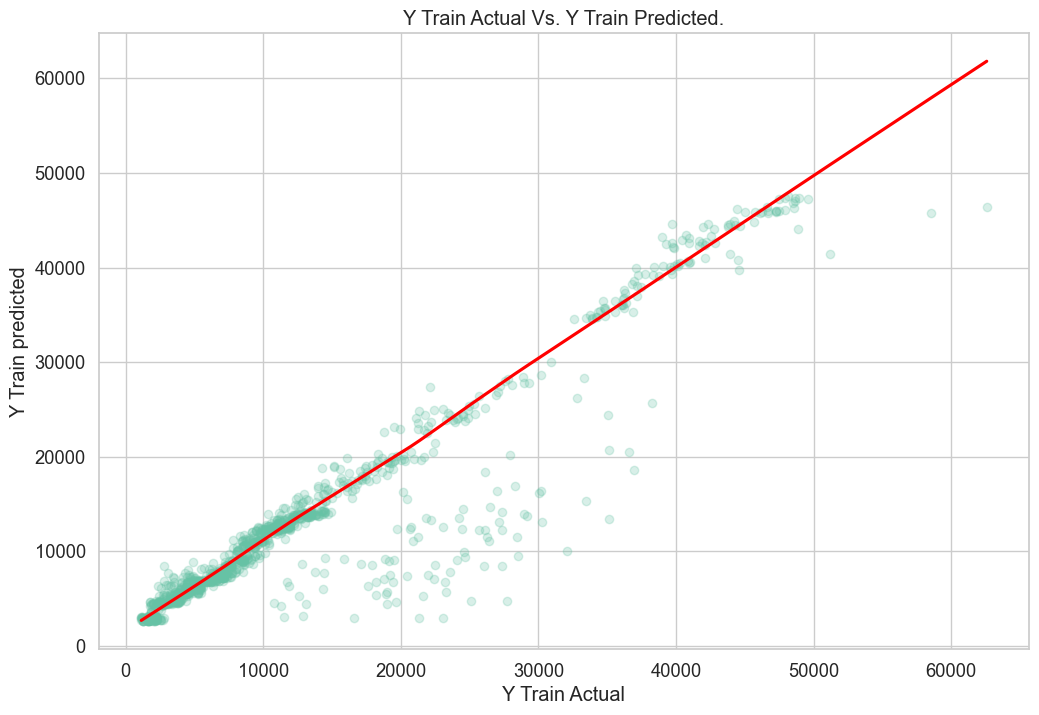

In [59]:
sns.regplot(x = y_train, y = predicted_train_data,
            lowess = True, ## Add a locally weighted scatterplot smoothing line
            line_kws = {'color': 'red'}, ## the color of the regression line
            scatter_kws = {'alpha': 0.25}) ## the transparency of the scatter points


plt.title("Y TRAIN ACTUAL VS. Y TRAIN PREDICTED.".title())
plt.xlabel("Y Train Actual")
plt.ylabel("Y Train predicted")
plt.show()

### Testing Data

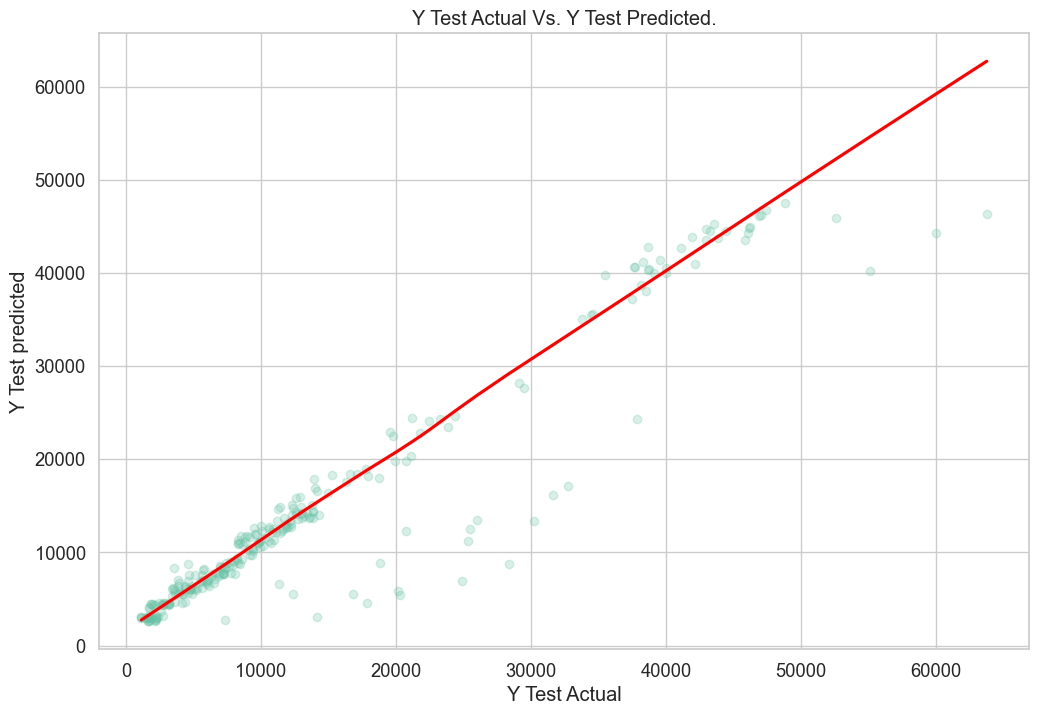

In [60]:
sns.regplot(
    x = y_test, y = predicted_test_data,
    lowess = True, ## Add a locally weighted scatterplot smoothing line
    line_kws = {'color': 'red'}, ## the color of the regression line
    scatter_kws = {'alpha': 0.25}) ## the transparency of the scatter points


plt.title("Y TEST ACTUAL VS. Y TEST PREDICTED.".title())
plt.xlabel("Y Test Actual")
plt.ylabel("Y Test predicted")
plt.show()

<div style="
    background-color: #5DADE2;
    text-align: center;
    padding: 10px;
    border-radius: 10px;
    margin: auto;
    font-weight: bold;
    color: white;
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    font-family: Arial, sans-serif;">
<ul>
    If you found this notebook helpful, please consider giving it an upvote. If you have any comments or questions, feel free to let me know!
</ul>
</div>